In [3]:
!git clone https://github.com/hpt1988/Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course

Cloning into 'Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course'...
remote: Enumerating objects: 22222, done.
remote: Counting objects: 100% (317/317), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 22222 (delta 134), reused 268 (delta 125), pack-reused 21905
Receiving objects: 100% (22222/22222), 317.99 MiB | 35.35 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Checking out files: 100% (21952/21952), done.


In [4]:
!ls Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course/behavioural_cloning/Data

driving_log.csv  IMG


# Preprocessing

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [6]:
datadir = 'Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course/behavioural_cloning/Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_154.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_154.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_154.jpg,0.0,0.0,0.0,0.000081
1,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_264.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_264.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_264.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_375.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_375.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_375.jpg,0.0,0.0,0.0,0.000080
3,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_489.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_489.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_489.jpg,0.0,0.0,0.0,0.000079
4,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_596.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_596.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_596.jpg,0.0,0.0,0.0,0.000079


In [7]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_06_29_11_07_08_154.jpg,left_2021_06_29_11_07_08_154.jpg,right_2021_06_29_11_07_08_154.jpg,0.0,0.0,0.0,0.000081
1,center_2021_06_29_11_07_08_264.jpg,left_2021_06_29_11_07_08_264.jpg,right_2021_06_29_11_07_08_264.jpg,0.0,0.0,0.0,0.000078
2,center_2021_06_29_11_07_08_375.jpg,left_2021_06_29_11_07_08_375.jpg,right_2021_06_29_11_07_08_375.jpg,0.0,0.0,0.0,0.000080
3,center_2021_06_29_11_07_08_489.jpg,left_2021_06_29_11_07_08_489.jpg,right_2021_06_29_11_07_08_489.jpg,0.0,0.0,0.0,0.000079
4,center_2021_06_29_11_07_08_596.jpg,left_2021_06_29_11_07_08_596.jpg,right_2021_06_29_11_07_08_596.jpg,0.0,0.0,0.0,0.000079


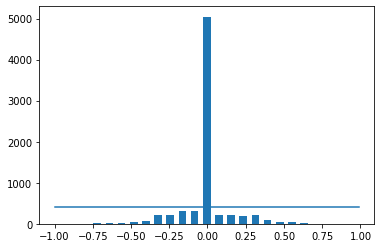

In [8]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  7300
removed:  4645
remaining:  2655


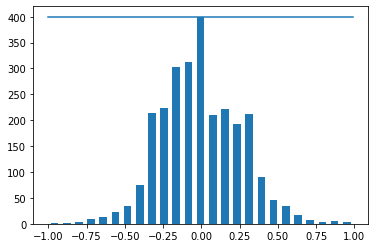

In [9]:
print('total data: ', len(data))
remove_list = []

for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [14]:
# Loading images as training data and corresponding steering angles as the label
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        # "iloc": allows to perform a selection on a row of data from data frame
        # based on thespecified index, which will simply be the current index
        # that's being iterated through. Therefore, "indexed_data" will contain
        # specific row of data at each iteration.
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        
        # "strip()" eliminates any spaces that may be present in the string
        # we only consider ceneter images for now
        image_path.append(os.path.join(datadir, center.strip()))

        steering.append(float(indexed_data[3]))

    image_paths = np.asarray(image_path)  # Convert list to array
    steerings = np.asarray(steering)  # Convert list to array
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

print(data.iloc[1])  # Illustration for "iloc"

center      center_2021_06_29_11_07_09_131.jpg
left        left_2021_06_29_11_07_09_131.jpg  
right       right_2021_06_29_11_07_09_131.jpg 
steering   -0.190757                          
throttle    0                                 
reverse     0                                 
speed       8.5504e-05                        
Name: 9, dtype: object


In [15]:
# Splitting the arrays to random training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 2124
Valid Samples: 531


Text(0.5, 1.0, 'Validation set')

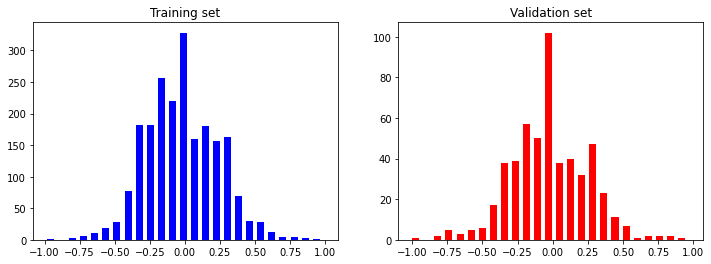

In [18]:
# To make sure both dataset (training and validation) include a uniform
# distribution of steering angles, such that both left and right steering angles
# are balanced, and model is a little bit more biased towards predicting 0 angle
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row and 2 columns
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')